# Análisis de texto

En este notebook se revisará distintas formas de realizar análisis de texto (básico) con Python.

## Contenido
1. N-grams
2. Sentiment analysis
3. Wordcloud
4. Referencias  

In [1]:
# load libraries
## basic libraries
import pandas as pd
import numpy as np

# Para visualización usaré Altair
import altair as alt
# alt.renderers.enable('mimetype') #<-Este nos sirve para ver las gráficas en GitHub
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [77]:
# Para eliminar stopwords
import nltk

# Para n-grams
import itertools
from collections import Counter

# Read txt file
import requests

import re

In [6]:
## librería spaCy
import spacy
nlp = spacy.load("es_core_news_sm")

In [62]:
# Cargamos el DF
df = pd.read_csv('motivo_renuncia.csv')

df = df[df['Motivo_renuncia'] != "0"].reset_index(drop=True)
df.columns = ["Motivo_renuncia"]

df.head(3)

,Motivo_renuncia
0,SE LE COMPLICÓ EL HORARIO DEL TRANSPORTE PARA ...
1,PROBLEMA PERSONAL
2,SOLO ACUDIÓ A INDUCCION


## 1. N-grams

In [15]:
# función para generar los n-grams
def n_gram(tokens,n):
    return[tokens[i:i+n] for i in range(len(tokens)-n+1)]

### *Bigrams* de caracteres

In [16]:
# Unir todos los motivos en un solo texto para calcular los bigramas
all_text = " ".join(df['Motivo_renuncia'].dropna())  # Unimos el texto, ignorando NaNs

# Dividir el texto en palabras
tokens = all_text.split()

# Calcular los bigramas
bigrams = Counter(zip(tokens, itertools.islice(tokens, 1, None)))

# Crear el DataFrame para los bigramas
source = pd.DataFrame(bigrams.values(), index=bigrams.keys()).reset_index()
source.columns = ["chr_1", "chr_2", "frecuencia"]

# Crear una columna 'bigram' que concatena los términos del bigrama
source["bigram"] = source["chr_1"] + " " + source["chr_2"]

# Mostrar los 10 bigramas más frecuentes
source = source.sort_values("frecuencia", ascending=False).head(10)
print(source)

         chr_1       chr_2  frecuencia                bigram
118      MEJOR      OFERTA          32          MEJOR OFERTA
0           SE          LE          20                 SE LE
11           A          SU          20                  A SU
174  PROBLEMAS  FAMILIARES          19  PROBLEMAS FAMILIARES
117        POR       MEJOR          14             POR MEJOR
176         NO          LE          13                 NO LE
162       BAJO   DESEMPEÑO          13        BAJO DESEMPEÑO
34         SUS       HIJOS          12             SUS HIJOS
33           A         SUS          10                 A SUS
38          YA          NO          10                 YA NO


In [17]:
# plot
alt.Chart(source).mark_bar().encode(
    alt.X("bigram",sort="-y"),
    y="frecuencia",
    tooltip=["bigram","chr_1","chr_2","frecuencia"]
).properties(
    title="Frecuencia de char-bigrams (con más de 1 repetición)"
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### *bigrams* de tokens (palabras o cadenas de caracteres)

In [75]:
# Mini-preproceso

## función para eliminar stopwords
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('spanish')
    output= [i for i in text if i not in stopwords]
    return output

## función de preproceso sencillo
def preproceso(texto):
    ## En minúsculas
    texto = texto.lower()
    ## Tokenization
    tokens = texto.rsplit()
    ## Eliminar Stopwords
    tokens = remove_stopwords(tokens)
    return tokens

## función de preproceso sencillo
def prepront(texto):
    ## En minúsculas
    texto = texto.lower()
    ## Eliminar Stopwords
    texto = remove_stopwords(texto)
    return texto

In [68]:
# aplicar función 'n_gram'
tokens_2 = preproceso(all_text)
my_bigrams = n_gram(tokens_2,2)  #<--Bigrams
print("\nLos primeros 10 bigrams:")
my_bigrams[:10]


Los primeros 10 bigrams:


[['complicó', 'horario'],
 ['horario', 'transporte'],
 ['transporte', 'llevar'],
 ['llevar', 'tiempo'],
 ['tiempo', 'hija'],
 ['hija', 'escuela'],
 ['escuela', 'problema'],
 ['problema', 'personal'],
 ['personal', 'solo'],
 ['solo', 'acudió']]

In [69]:
# frecuencia de token's bigrams
# df_tokens = pd.DataFrame(Counter(zip(pd.DataFrame(my_bigrams)[0], pd.DataFrame(my_bigrams)[1])))
bigram_freq = Counter(zip(pd.DataFrame(my_bigrams)[0], pd.DataFrame(my_bigrams)[1]))

# hacer un dataframe para poder graficarlo
# my_cols = [str(i) for i in bigram_freq.keys()]
# bigram_freq.values()
source = pd.DataFrame(bigram_freq.values(), index=bigram_freq.keys()).reset_index().rename(columns={"level_0":"token_1", "level_1":"token_2", 0:"frecuencia"})
source["bigram"] = source["token_1"] + " " + source["token_2"]
source


,token_1,token_2,frecuencia,bigram
0,complicó,horario,2,complicó horario
1,horario,transporte,1,horario transporte
2,transporte,llevar,1,transporte llevar
3,llevar,tiempo,1,llevar tiempo
4,tiempo,hija,1,tiempo hija
...,...,...,...,...
868,recien,nacido,2,recien nacido
869,nacido,vive,1,nacido vive
870,transporte,embarazo,1,transporte embarazo
871,embarazo,complicado,1,embarazo complicado


In [70]:
source.sort_values(by="frecuencia", ascending=False).head(15)

,token_1,token_2,frecuencia,bigram
72,mejor,oferta,32,mejor oferta
117,problemas,familiares,19,problemas familiares
107,bajo,desempeño,13,bajo desempeño
60,temas,personales,9,temas personales
208,sem,49,8,sem 49
196,sem,45,8,sem 45
104,problema,familiar,7,problema familiar
9,solo,acudió,7,solo acudió
295,cambia,residencia,6,cambia residencia
67,turno,c,6,turno c


In [71]:
# plot
alt.Chart(source[source.frecuencia>2]).mark_bar().encode(
    alt.X("bigram",sort="-y"),
    y="frecuencia",
    tooltip=["bigram","token_1","token_2","frecuencia"]
).properties(
    title="Frecuencia de token-bigrams (con más de 2 repeticiones)"
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Bigram plot




In [25]:
# load libraries for bigram plot
import string
import nltk
from nltk.collocations import *
import networkx
import networkx as nx
import matplotlib.pyplot as plt

# Download stopwords data if not already downloaded
nltk.download('stopwords')  # This line downloads the stopwords data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
# Preproceso del texto

## Eliminar signos de puntuación
signos_puntuacion = string.punctuation
#### función para eliminar signos de puntuación
def remove_punctuation(text, signos=signos_puntuacion):
    punctuationfree="".join([i for i in text if i not in signos])
    return punctuationfree

## Texto preprocesado: eliminar puntuación y salto de renglón,
##        y texto en minúsculas
texto_preprocess = remove_punctuation(all_text).replace("\n", " ").lower()

## Obtener tokens
tokens = nltk.wordpunct_tokenize(texto_preprocess)

## Eliminar stopwords
stopwords = nltk.corpus.stopwords.words('spanish')
### función para eliminar stopwords
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output
# eliminar stopwrods de tokens
tokens_clean = remove_stopwords(tokens)

In [27]:
# bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens_clean)
scored = finder.score_ngrams(bigram_measures.raw_freq)

In [28]:
# Create a network plot of grouped terms
# Para esto se usa una gráfica de grafos en este caso
bigram_df = pd.DataFrame(scored,
                             columns=['bigram', 'count'])
bigram_df_head = bigram_df.sort_values(by="count", ascending=False).head(25)

# Create dictionary of bigrams and their counts
d = bigram_df_head.set_index('bigram').T.to_dict('records')

# Create network plot
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

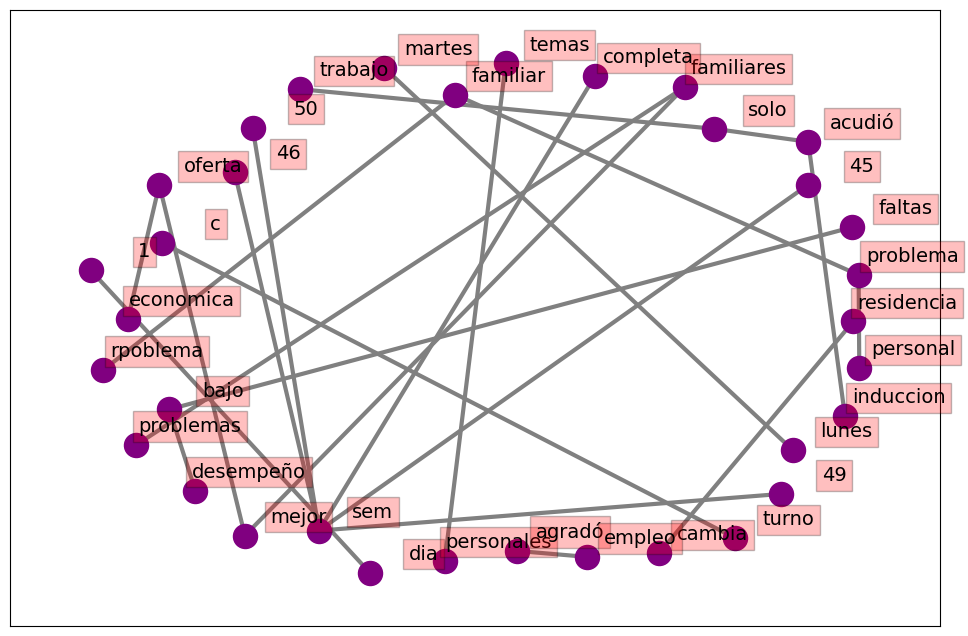

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(G, k=5.5)
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.05
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=14)

plt.show()

plt.savefig("\results\analisis_sentimientos_Bigram.png", format="png")

## 2. Sentiment analysis
Herramienta para identificar si un texto es positivo o negativo.

In [32]:
from spacytextblob.spacytextblob import SpacyTextBlob

### 2.1. Token's sentiment analysis

In [34]:
# get text in English
nlp = spacy.load("es_core_news_sm")

In [35]:
# add the sentiment
nlp.add_pipe("spacytextblob")
doc = nlp(all_text)

In [36]:
# put it in a dataframe
df = pd.DataFrame()

for token in doc:
    df_1 = pd.DataFrame({
        "token":token.text, "tag":token.pos_,
        "polarity":token._.blob.polarity,
        "subjectivity":token._.blob.subjectivity
    }, index=[0])
    df = pd.concat([df, df_1])#.reset_index(drop=True)

In [37]:
# print the table for polarity and subjectivity values different to zero
df_2 = df[(df.subjectivity != 0) | (df.polarity != 0)].reset_index(drop=True)
df_2

,token,tag,polarity,subjectivity
0,PERSONAL,PROPN,0.000,0.30
1,FAMILIAR,PROPN,0.375,0.50
2,FAMILIAR,PROPN,0.375,0.50
3,COOL,PROPN,0.350,0.65
4,COOL,PROPN,0.350,0.65
5,PERSONAL,PROPN,0.000,0.30
6,FAMILIAR,ADJ,0.375,0.50
7,FAMILIAR,PROPN,0.375,0.50
8,FAMILIAR,PROPN,0.375,0.50
9,PERSONAL,PROPN,0.000,0.30


In [ ]:
# plot
alt.Chart(df).mark_bar().encode(
    alt.X('polarity', bin=True, title="Sentiment polarity"),
    alt.Y('count()', scale=alt.Scale(type="log"), title="Frequency"),
    tooltip=['polarity', 'count()']
).properties(
    title="Histogram of token's sentiment"
)
# Sentiment score is a float within the range
#    -1.0 (negative) to 1.0 (positive). 

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

In [39]:
# plot
alt.Chart(df).mark_circle(opacity=.4, size=50).encode(
    alt.X('subjectivity', title="Subjectivity"),
    alt.Y('polarity', title="Polarity"),
    alt.Color('tag'),
    tooltip=['token','polarity','subjectivity']
).properties(
    title="Scatter plot of Polarity vs. Subjectivity by token"
)
# Polarity score are a float within the range -1.0 (negative) to
# 1.0 (positive), and subjectivity from 0.0 to 1.0

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### 2.2. Sentence / paragraph sentiment analysis

In [63]:
# Suponiendo que `df` es tu DataFrame original con la columna "motivo_renuncia"
df_sent = pd.DataFrame()

# Iterar sobre cada registro de la columna 'motivo_renuncia'
for motivo in df["Motivo_renuncia"]:
    doc = nlp(motivo)  # Procesar el texto con spaCy
    df_1 = pd.DataFrame({
        "paragraph": [doc.text],
        "polarity": [doc._.blob.polarity],
        "subjectivity": [doc._.blob.subjectivity]
    })
    df_sent = pd.concat([df_sent, df_1], ignore_index=True)

In [65]:
# Filtrar valores de polaridad y subjetividad diferentes de cero
df_sent_filtered = df_sent[(df_sent.subjectivity != 0) | (df_sent.polarity != 0)].reset_index(drop=True)

df_sent_filtered

,paragraph,polarity,subjectivity
0,PROBLEMA PERSONAL,0.000,0.30
1,CONFLICTO FAMILIAR CON UNA COMPAÑERA,0.375,0.50
2,PROBLEMA FAMILIAR,0.375,0.50
3,COMENTA QUE DONDE TOMA EL TRANSPORTE DE COOL P...,0.350,0.65
4,PARA TRABAJAR EN LAMISMA EMPRESA A LA QUE ENTR...,0.350,0.65
5,PROBLEMA PERSONAL,0.000,0.30
6,TUVO UN RPOBLEMA FAMILIAR,0.375,0.50
7,OPERARON A UN FAMILIAR FUERA DE GDL,0.375,0.50
8,ASUNTO FAMILIAR,0.375,0.50
9,MENCIONA QUE TUVO PROBLEMA PERSONAL,0.000,0.30


In [66]:
# plot
alt.Chart(df_sent).mark_circle(opacity=.4, size=50).encode(
    alt.X('subjectivity:Q', title="Subjectivity"),
    alt.Y('polarity:Q', title="Polarity"),
    tooltip=['paragraph','polarity','subjectivity']
).properties(
    title="Scatter plot of Polarity vs. Subjectivity by Paragraph"
)
# Polarity score are a float within the range -1.0 (negative) to
# 1.0 (positive), and subjectivity from 0.0 to 1.0

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

## 3. Wordcloud
Esta es una herramienta visual con la que se observa qué tanto se repite una palabra de acuerdo al tamaño que tiene en la *wordcloud*.

### 3.1. Sin *mask* de *background*

In [44]:
# load libraries for WordCloud
from textblob import TextBlob
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

In [ ]:
# Procesar el texto con spaCy
doc = nlp(all_text)

# Reconstruir el texto sin stopwords ni signos de puntuación, y en minúsculas
filtered_text = " ".join(
    [
        token.text.lower()  # Convertir a minúsculas
        for token in doc
        if not token.is_stop and not token.is_punct
    ]
)

# Reemplazar múltiples espacios por uno solo
filtered_text = re.sub(r"\s+", " ", filtered_text).strip()

# Mostrar el texto filtrado
print(filtered_text)

In [79]:
## data
# para data usamos la canción de Tutu text_2
# o podemos usar el libro de harry potter  text_3

# get wordcloud
wcloud = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211,
                   background_color='white', max_words=400, collocations=False,
                   mode='RGBA').generate(filtered_text)

(-0.5, 2999.5, 1699.5, -0.5)

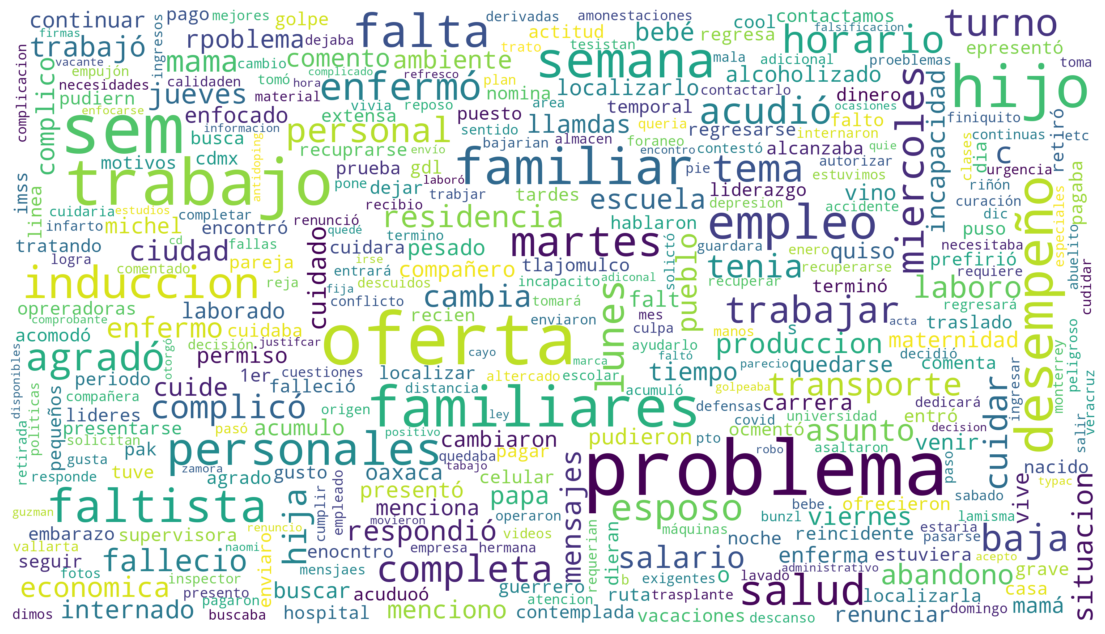

In [80]:
# plot
plt.figure(figsize=(14,8))

# create coloring from image
plt.imshow(wcloud.recolor(), interpolation="bilinear")
plt.axis("off")

# # store to file
plt.savefig("\results\analisis_sentimientos_wordcloud.png", format="png")

### 3.2. Con *mask* de *background*

In [53]:
## data and mask
mask = np.array(Image.open('worker.png'))  # 'img/02-01_webpage.png'

In [81]:
# get wordcloud
wcloud = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211,
                   background_color='black', max_words=400, collocations=False,
                   mode='RGBA',mask=mask).generate(filtered_text)

(-0.5, 1255.5, 599.5, -0.5)

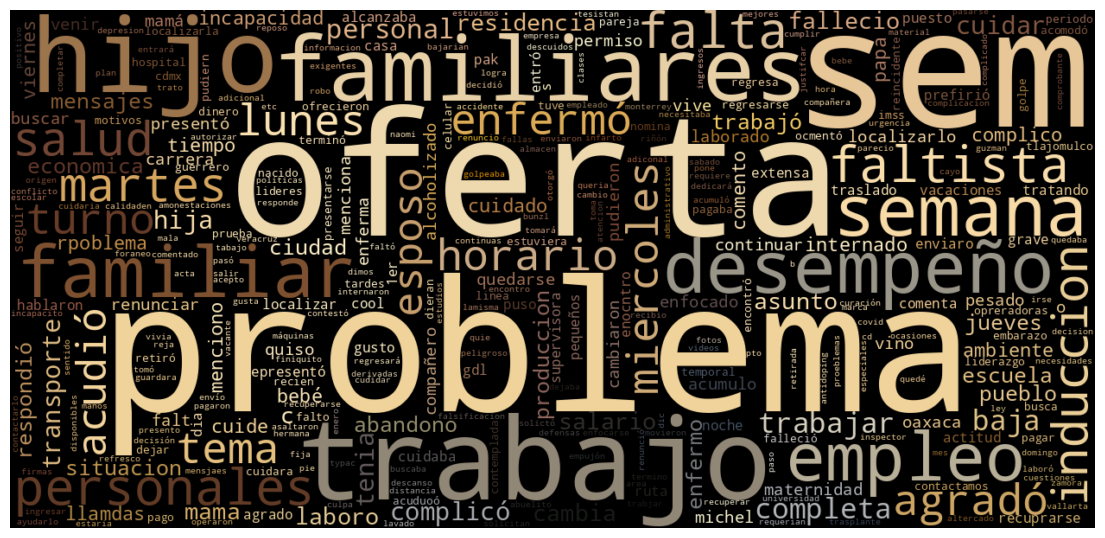

In [82]:
# plot
plt.figure(figsize=(14,8))

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.imshow(wcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# # store to file
# plt.savefig("img/19-03_wordcloud_mask.jpg", format="jpg")

## 4. Referencias
- spaCy's [textblob](https://spacy.io/universe/project/spacy-textblob)
- [SpaCy For Traditional NLP](https://chatbotslife.com/spacy-for-traditional-nlp-c85b5436b21c) por saketh-saraswathi en *Chatbots Life*.
- Earth Lab. [Lesson 6. Use Twitter Data to Explore the 2013 Colorado Flood Using Open Source Python](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/json-colorado-flood-twitter-data/).
- NLTK. [Sample usage for collocations](https://www.nltk.org/howto/collocations.html).